In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
import json
import dataclasses
import os
import csv
import collections

@dataclasses.dataclass
class Answer:
	eye_shape : str
	eyebrow : str
	iris : str
	pupil : str
	prompt: str = ""

@dataclasses.dataclass
class Data:
	id : str
	answers : list[Answer]

@dataclasses.dataclass
class MultiData:
	id : str
	game : list[Answer]
	questionnaire : list[Answer]


EYE_SHAPE_TR = {
	"?"		: "Eye4",
	"??"	: "Eye5",
	"???"	: "Eye6",
	"????"	: "Eye2",
	"?????" : "Eye1",
	"??????": "Eye3",
}

IRIS_TR = {
	"1" : "Iris1",
	"2" : "Iris4",
	"3" : "Iris6",
	"4" : "Iris5",
	"5" : "Iris3",
	"6" : "Iris2",
}

PUPIL_TR = {
	"1" : "Pupil4",
	"2" : "Pupil6",
	"3" : "Pupil5",
	"4" : "Pupil3",
	"5" : "Pupil1",
	"6" : "Pupil2",
}

EYEBROW_TR = {
	"1" : "Eyebrow4",
	"2" : "Eyebrow5",
	"3" : "Eyebrow6",
	"4" : "Eyebrow2",
	"5" : "Eyebrow3",
	"6" : "Eyebrow1",
}


def load_main_questionnaire(path = "./main_questionnaire.csv")->list[Data]:
	ret :list[Data] = []
	with open(path, "r", encoding="utf-8") as csvfile:
		is_first_line = True
		for row in csv.reader(csvfile):
			if is_first_line: # skip the header
				is_first_line = False
				continue
			current_data = Data(0, [])
			current_data.id = row[2]
			for i in range(6, len(row), 4):
				current_data.answers.append(Answer(
					EYE_SHAPE_TR[row[i]],
					EYEBROW_TR[row[i+3]],
					IRIS_TR[row[i+1]],
					PUPIL_TR[row[i+2]],
				))
			ret.append(current_data)
	return ret


def load_log_raw(path)->dict:
	with open(path, "r") as f:
		return json.load(f)
	

def load_log(path)->Data:
	raw = load_log_raw(path)
	ret = Data(0, [])
	current_prompt = "<nil>"
	for entry in raw:
		entry_type = entry['type']
		if entry_type == 'user_id':
			ret.id = entry['id']
		if entry_type == 'dialog_node_start':
			if "Fn_Main" in str(entry['node_path']):
				current_prompt = str(entry['node_path']).split('/')[-2]
		if entry_type == 'submit_answer':
			ret.answers.append(Answer(
				entry['eye_shape'],
				entry['eyebrow'],
				entry['iris'],
				entry['pupil'],
				current_prompt
			))
	ret.answers = ret.answers[2:] ## remove the first 2 tutorial prompts
	return ret

def load_logs(dir_path = "./game_logs")->list[Data]:
	ret :list[Data] = []
	for path in os.scandir(dir_path):
		if path.is_file():
			ret.append(load_log(path.path))
	return ret

def get_answers_to_question(data : list[Data], question_idx):
	return [x.answers[question_idx] for x in data]


def get_fields(data, field_name):
	return [getattr(f, field_name) for f in data]

def get_counts(data: list):
	ret = collections.defaultdict(int)
	for elem in data:
		ret[elem] += 1
	existing_data = list(ret.keys())
	existing_data.sort()
	return (existing_data, [ret[e] for e in existing_data])

def get_pretty_name(raw:str)->str:
	return raw.replace("_", " ").capitalize()

In [2]:
questionnaire_raw = load_main_questionnaire()
gamelogs_raw = load_logs()
questionnaire_ids = {qe.id : qe for qe in questionnaire_raw}
game_ids = {qe.id : qe for qe in gamelogs_raw}
matching_ids = {x for x in questionnaire_ids.keys() if x in game_ids.keys()}

questionnaire = [questionnaire_ids[id] for id in matching_ids]
gamelogs = [game_ids[id] for id in matching_ids]
data = [MultiData(id, game_ids[id].answers, questionnaire_ids[id].answers ) for id in matching_ids]
QUESTIONS_COUNT = len(data[0].game)



## Answers for each prompt - per eye part (Game VS Questionnaire)

NeedsToForgetWhatHeDid


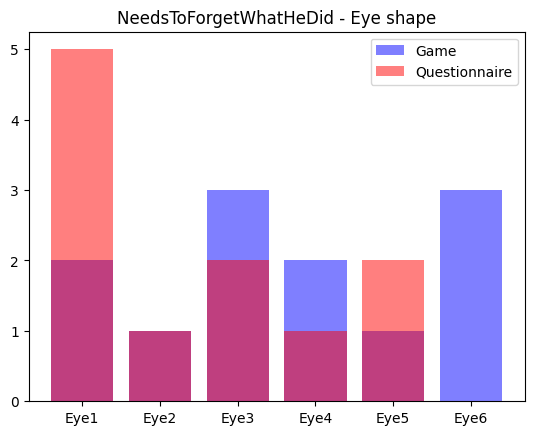

NeedsToForgetWhatHeDid


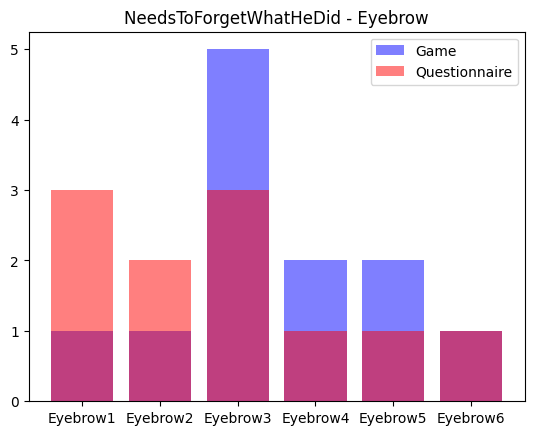

NeedsToForgetWhatHeDid


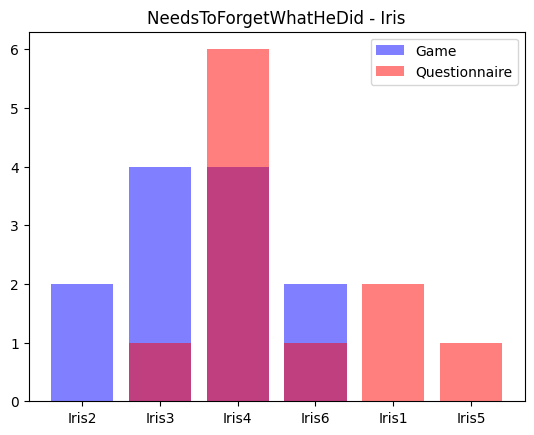

NeedsToForgetWhatHeDid


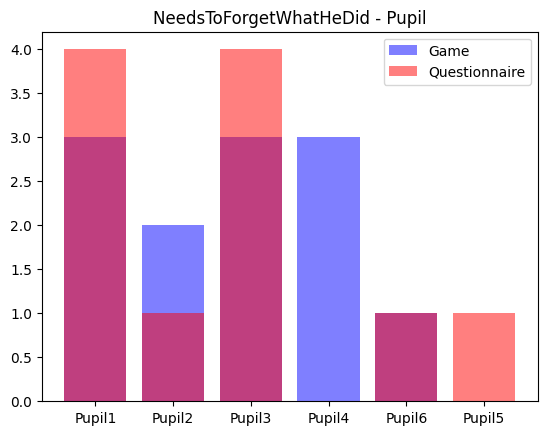

LoyalKnight


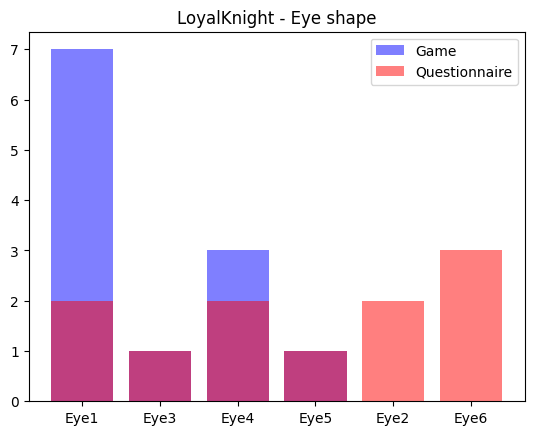

LoyalKnight


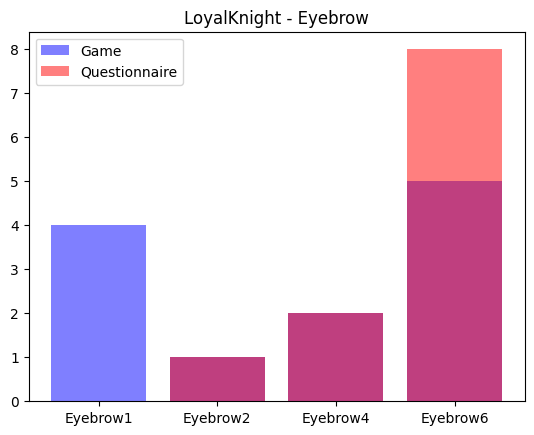

LoyalKnight


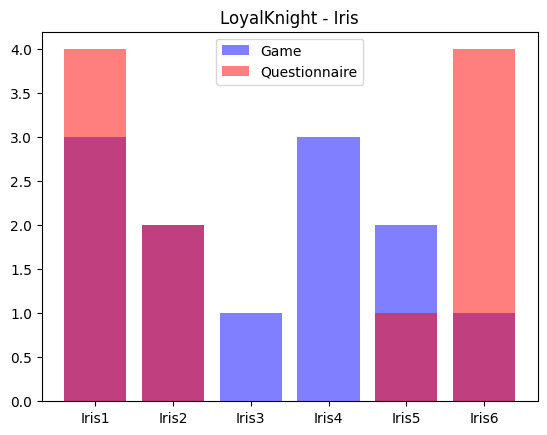

LoyalKnight


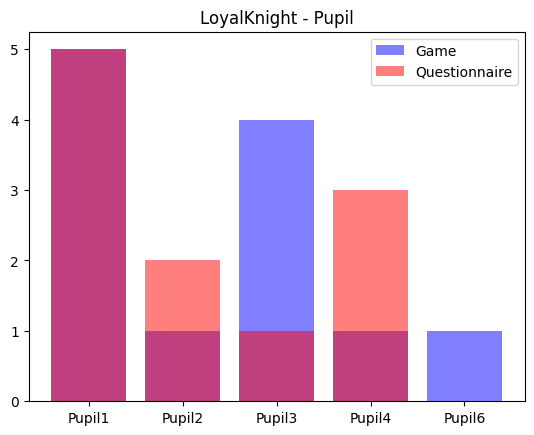

Vain


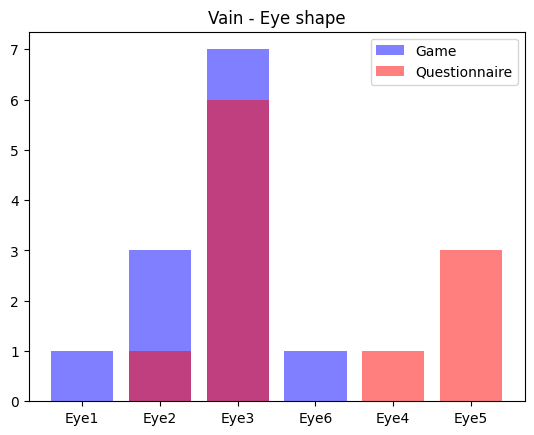

Vain


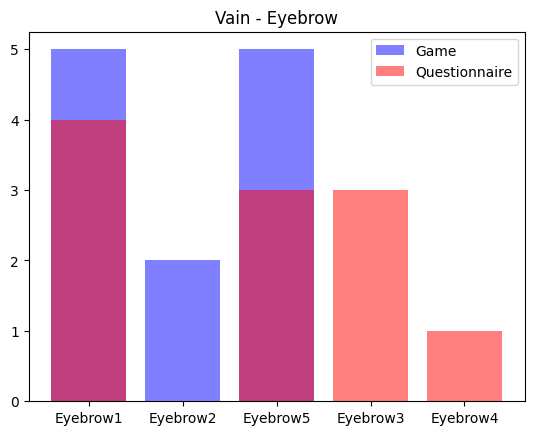

Vain


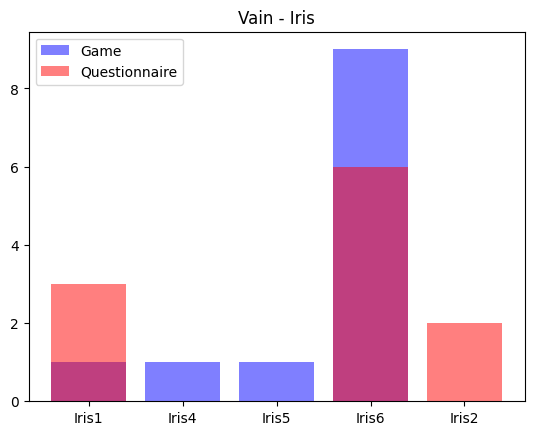

Vain


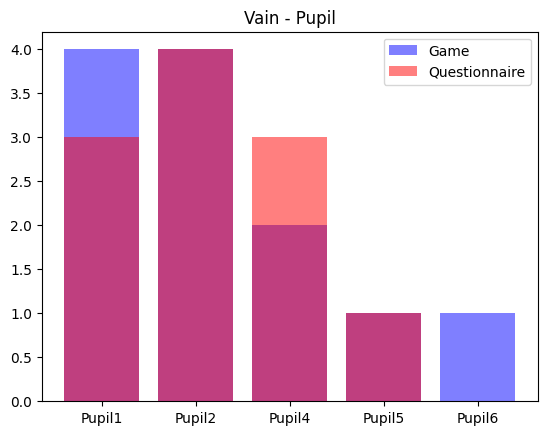

GentleWerewolf


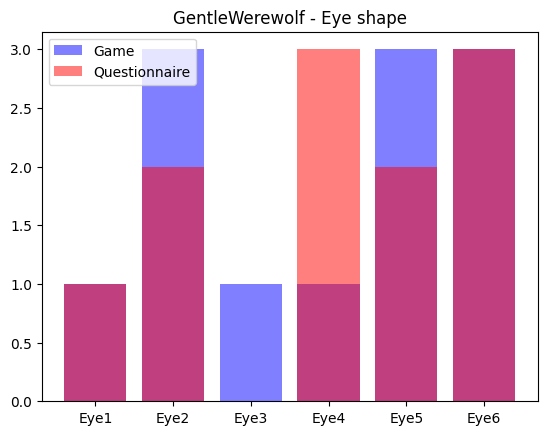

GentleWerewolf


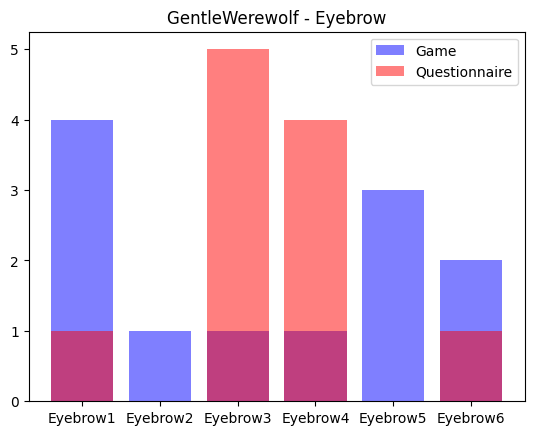

GentleWerewolf


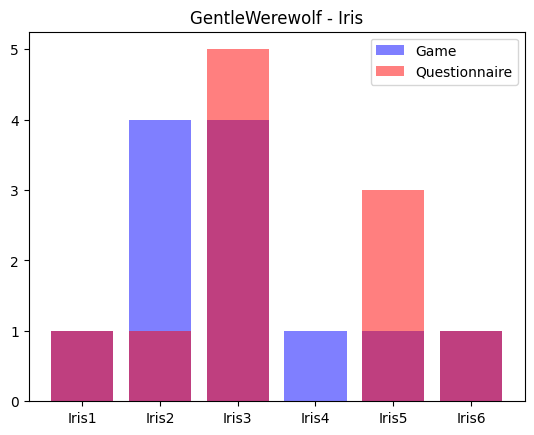

GentleWerewolf


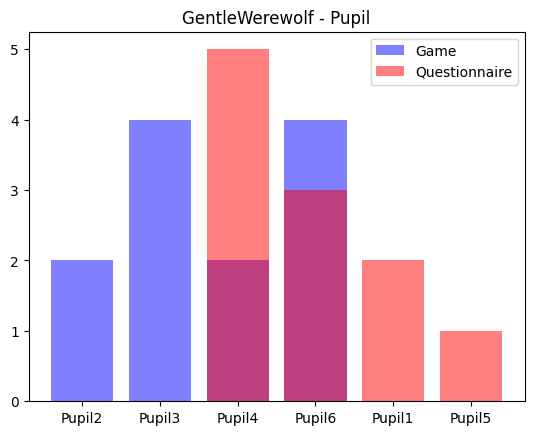

Gambler


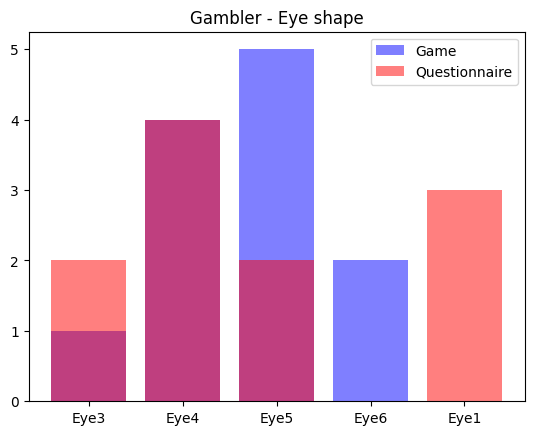

Gambler


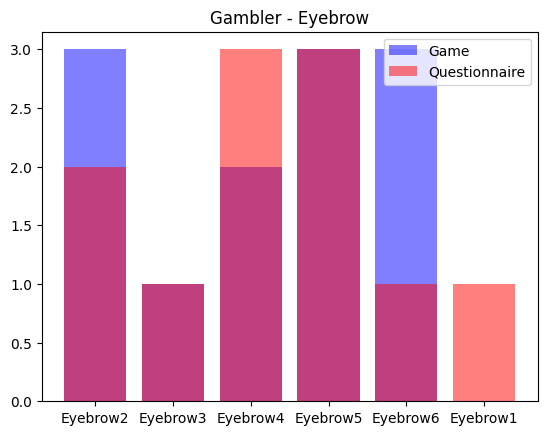

Gambler


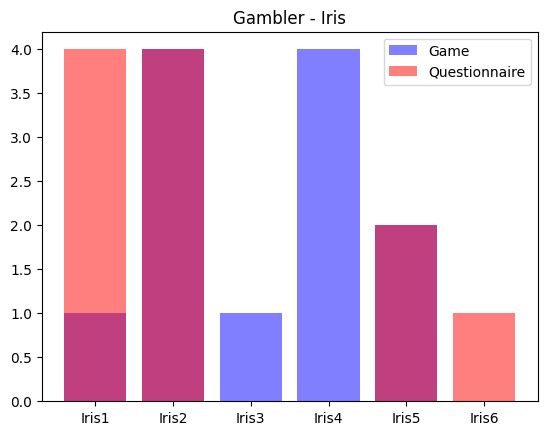

Gambler


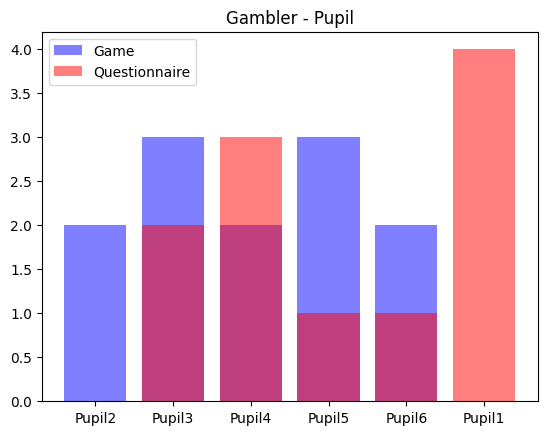

PoorPeasant


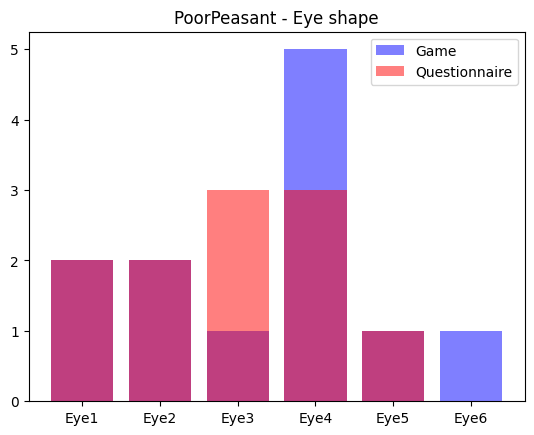

PoorPeasant


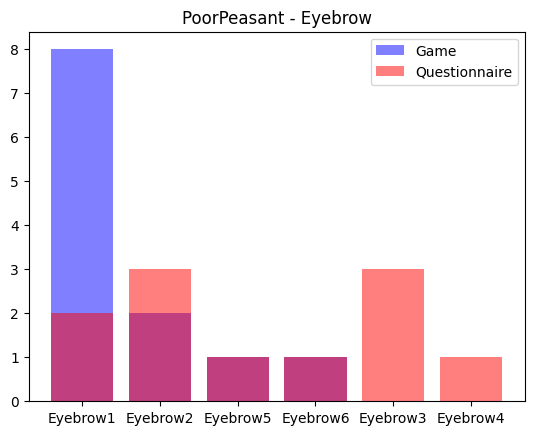

PoorPeasant


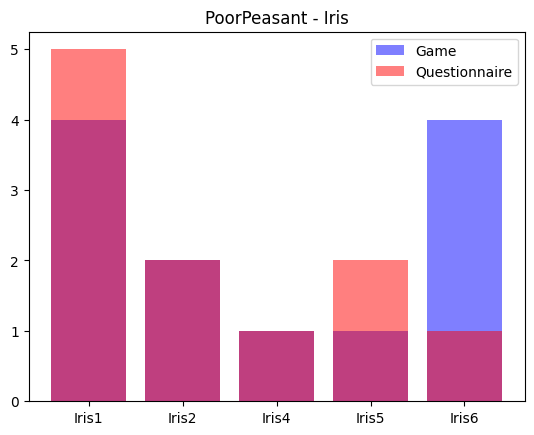

PoorPeasant


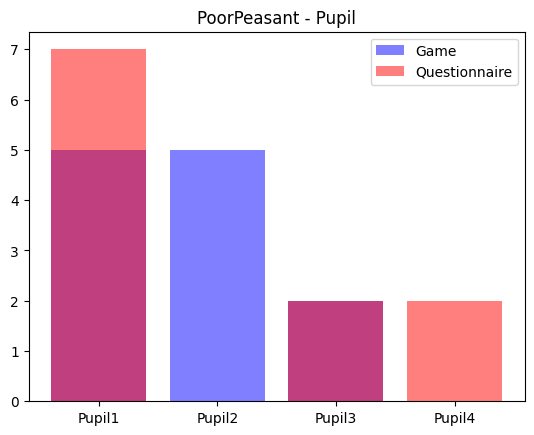

Warlock


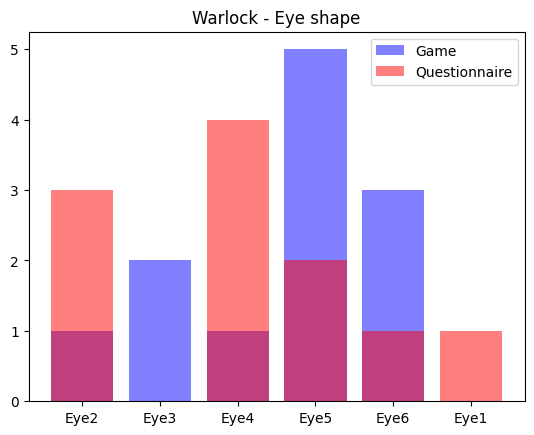

Warlock


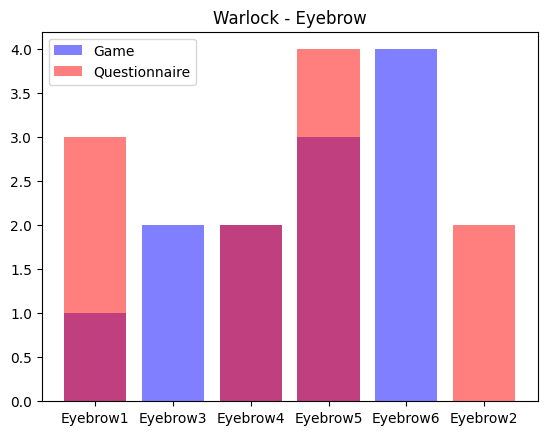

Warlock


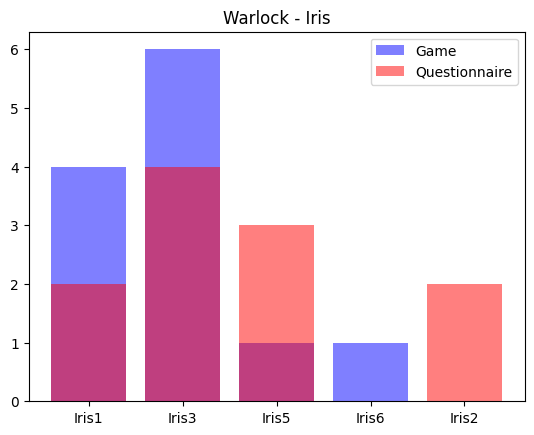

Warlock


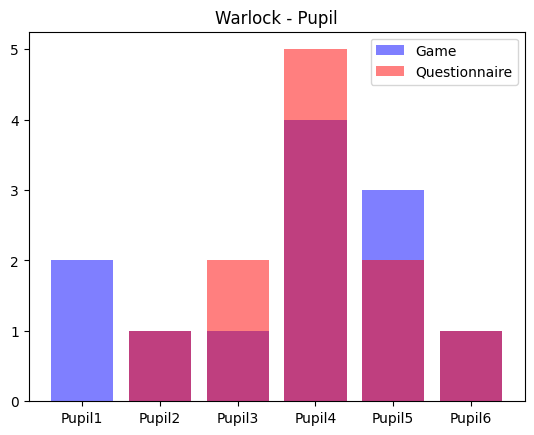

BookEnjoyer


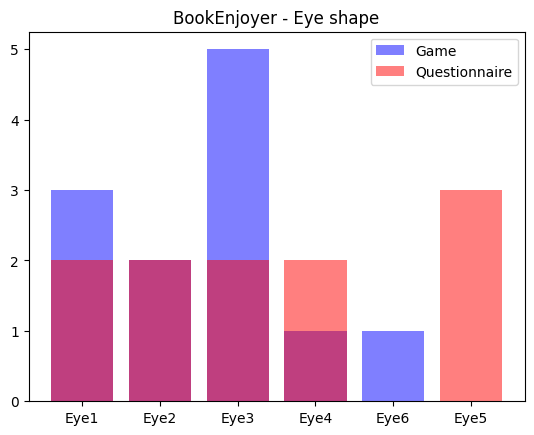

BookEnjoyer


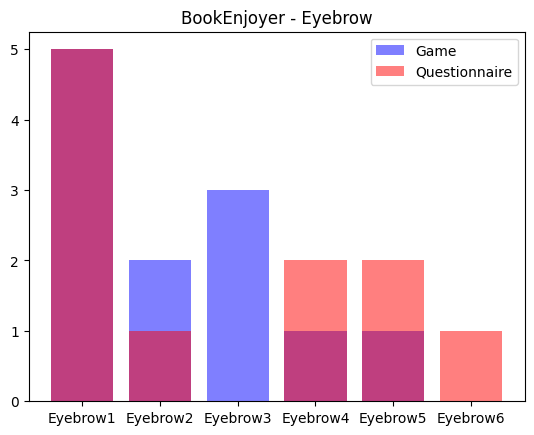

BookEnjoyer


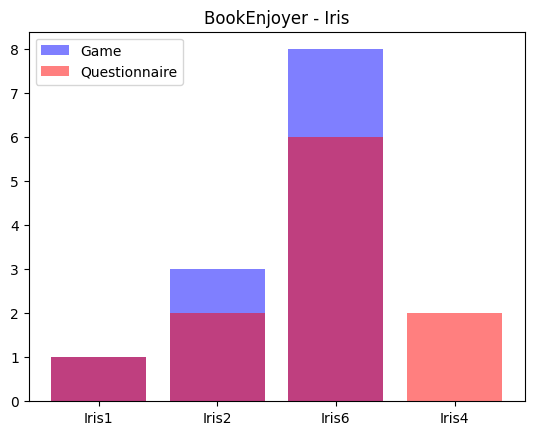

BookEnjoyer


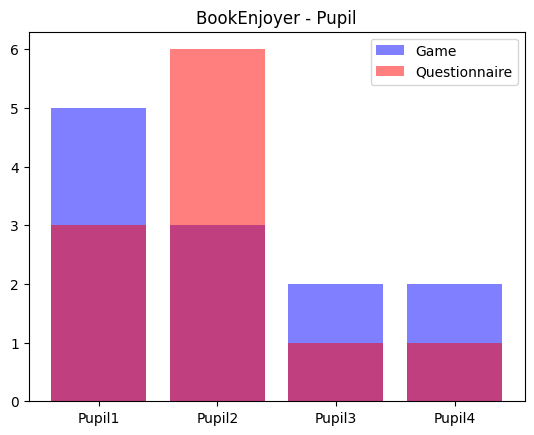

FormerVizier


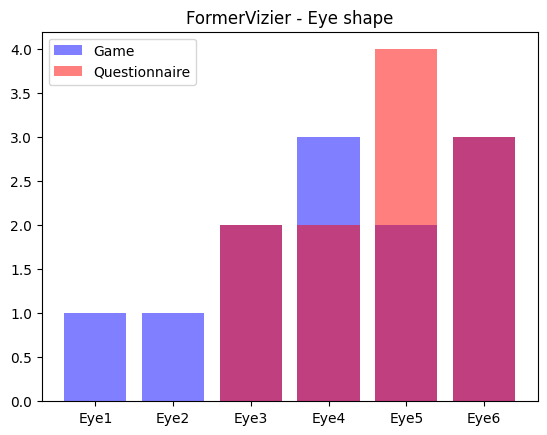

FormerVizier


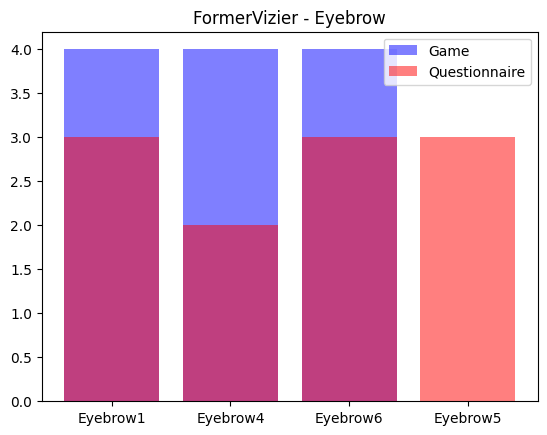

FormerVizier


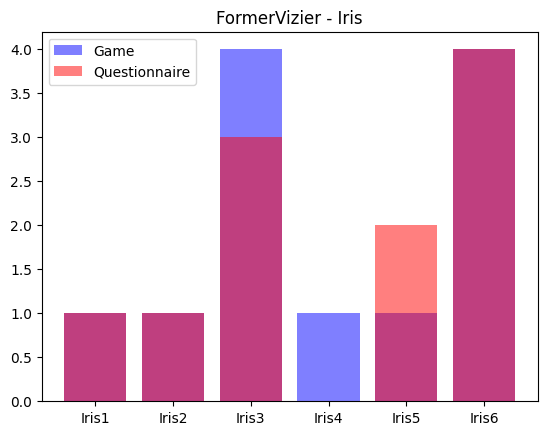

FormerVizier


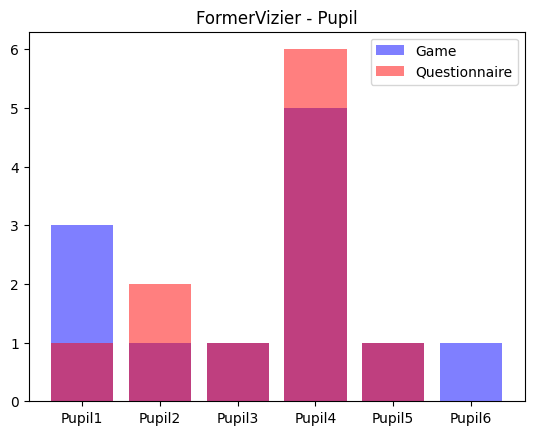

MadScientist


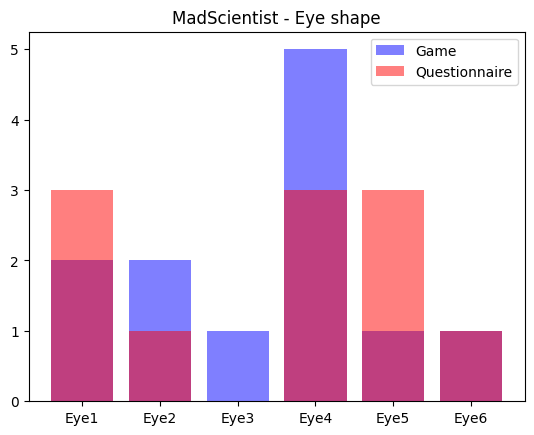

MadScientist


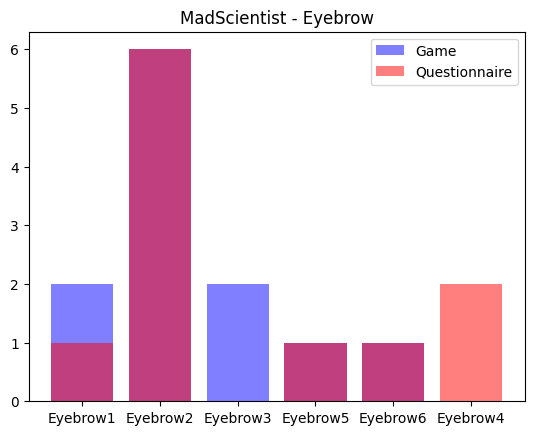

MadScientist


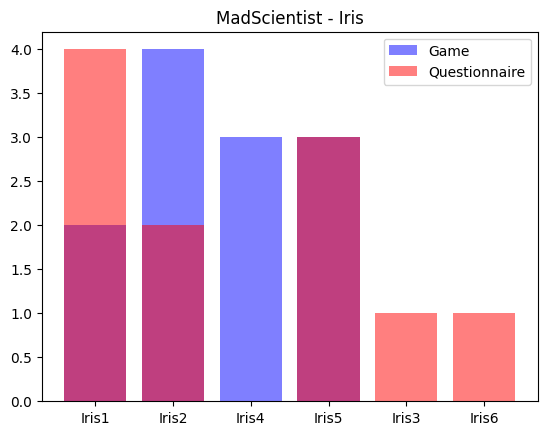

MadScientist


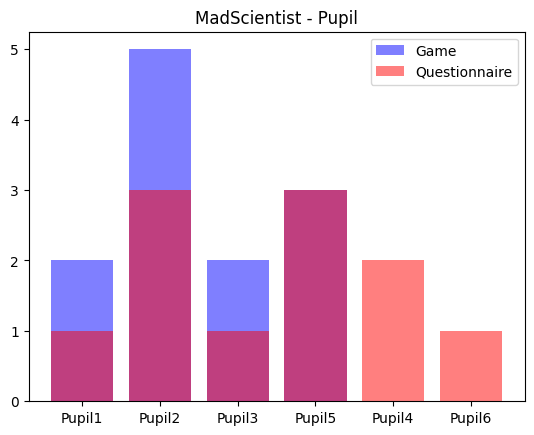

Archmage


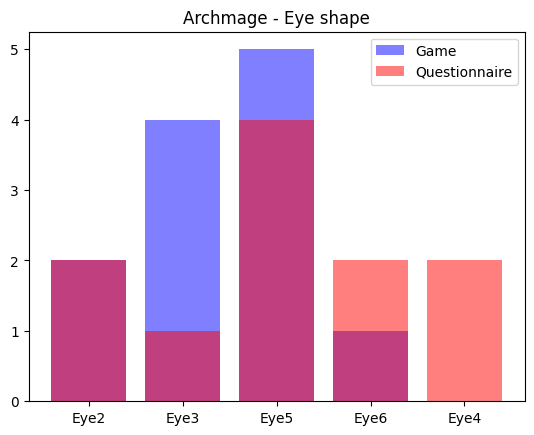

Archmage


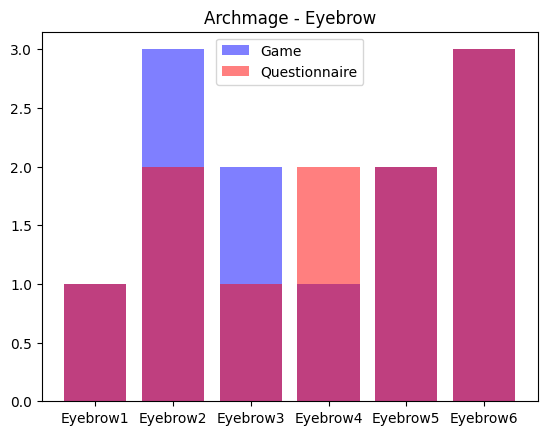

Archmage


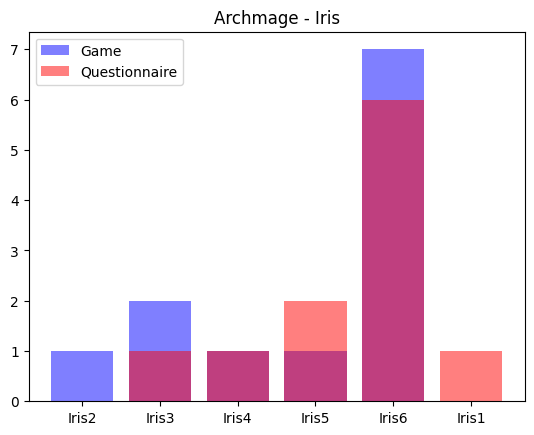

Archmage


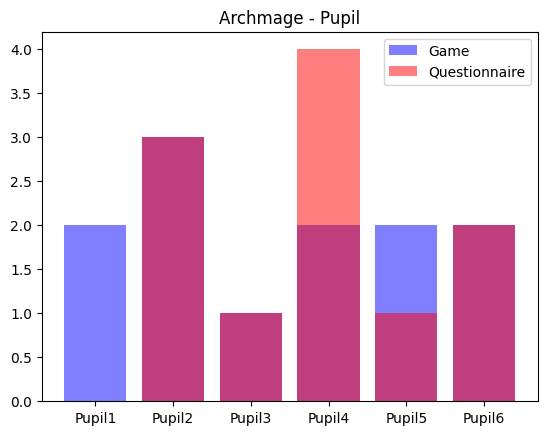

In [3]:
for idx in range(QUESTIONS_COUNT - 1):
	game = get_answers_to_question(gamelogs_raw, idx)
	ques = get_answers_to_question(questionnaire_raw, idx)
	
	def plot_counts(part):
		prompt = game[0].prompt
		print(game[0].prompt)
		plt.title(prompt + " - " + get_pretty_name(part))
		plt.bar(*get_counts(get_fields(game, part)), color="#0000ff", alpha=0.5)
		plt.bar(*get_counts(get_fields(ques, part)), color="#ff0000", alpha=0.5)
		plt.legend(["Game", "Questionnaire"])
		#ax = plt.figure().gca()
		#ax.yaxis.set_major_locator(MaxNLocator(integer=True))
		plt.show()

	plot_counts("eye_shape")
	plot_counts("eyebrow")
	plot_counts("iris")
	plot_counts("pupil")



## Answers for each prompt - per eye assembly (Game VS Questionnaire)

In [4]:

def generate_Nplets(arr:list, N:int):
	if N == 1:
		for a in arr:
			yield [a]
		return
	for i in range(len(arr)):
		for b in generate_Nplets(arr[(i+1):], N-1):
			yield [arr[i]] + b

for idx in range(QUESTIONS_COUNT - 1):
	game = get_answers_to_question(gamelogs_raw, idx)
	ques = get_answers_to_question(questionnaire_raw, idx)
	

	
	def process_counts(data: list[Answer], name):
		def combine_answer(ans : list)->str:
			return " + ".join(ans)
		def list_answer(ans : Answer)->list[str]:
			return [ans.eye_shape, ans.eyebrow, ans.iris, ans.pupil]


		counts = collections.defaultdict(int)
		for ans in data:
			counts[combine_answer(list_answer(ans))] += 1
		ret = [(counts[k], k) for k in counts]
		ret.sort(reverse=True)
		print(name)
		print(f"\t\t{len(ret)} unique answers")
		for r in ret:
			if r[0] <= 1: break
			print(f"\t\t{r[0]} times ... {r[1]}")
		
		for N in [3, 2]:
			Ncounts = collections.defaultdict(int)
			for ans in data:
				for nplet in generate_Nplets(list_answer(ans), N):
					Ncounts[combine_answer(nplet)] += 1
			Nlist = [(Ncounts[k], k) for k in Ncounts]
			Nlist.sort(reverse=True)
			if len(Nlist) > 0 and Nlist[0][0] > 1:
				cluster_counts = collections.defaultdict(int)
				for r in Nlist:
					if r[0] <= 1: break
					cluster_counts[r[0]] += 1
				cluster_counts_list = [(k, cluster_counts[k]) for k in cluster_counts.keys()]
				cluster_counts_list.sort(reverse=True)

				print(f"\n\t\t{N}-plets...")
				for (cluster_magnitude, clusters_count) in cluster_counts_list:
					print(f"\t\t\t- {clusters_count} of cluster size {cluster_magnitude}")
				for r in Nlist:
					if r[0] <= 1: break
					print(f"\t\t\t{r[0]} times ... {r[1]}")
			

		print("\n")


	def plot_counts():
		print(f"Prompt: '{game[0].prompt}'")
		process_counts(game, "\tGame...")
		process_counts(ques, "\tQuestionnaire...")

	plot_counts()



Prompt: 'NeedsToForgetWhatHeDid'
	Game...
		12 unique answers

		3-plets...
			- 1 of cluster size 2
			2 times ... Eye3 + Eyebrow3 + Iris3

		2-plets...
			- 1 of cluster size 3
			- 6 of cluster size 2
			3 times ... Eyebrow3 + Iris3
			2 times ... Iris3 + Pupil3
			2 times ... Eyebrow3 + Pupil3
			2 times ... Eyebrow3 + Iris4
			2 times ... Eye3 + Pupil1
			2 times ... Eye3 + Iris3
			2 times ... Eye3 + Eyebrow3


	Questionnaire...
		11 unique answers

		3-plets...
			- 1 of cluster size 2
			2 times ... Eye1 + Eyebrow1 + Pupil1

		2-plets...
			- 2 of cluster size 3
			- 6 of cluster size 2
			3 times ... Eye1 + Pupil1
			3 times ... Eye1 + Iris4
			2 times ... Iris4 + Pupil3
			2 times ... Eyebrow3 + Iris4
			2 times ... Eyebrow1 + Pupil1
			2 times ... Eyebrow1 + Iris4
			2 times ... Eye5 + Iris4
			2 times ... Eye1 + Eyebrow1


Prompt: 'LoyalKnight'
	Game...
		12 unique answers

		3-plets...
			- 1 of cluster size 3
			- 2 of cluster size 2
			3 times ... Eye1 + Eyebrow6 + Pupil

## For each eye part - How much it was used throughout the prompts (Game VS Questionnaire)

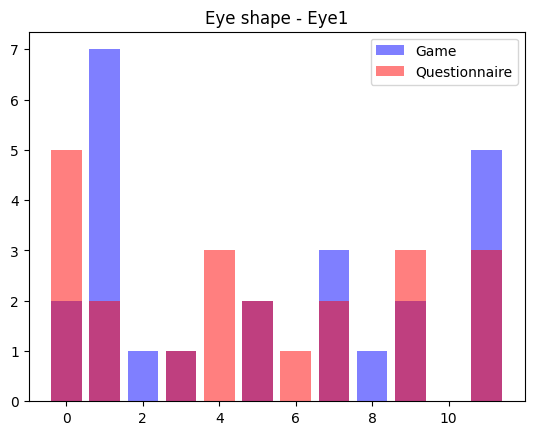

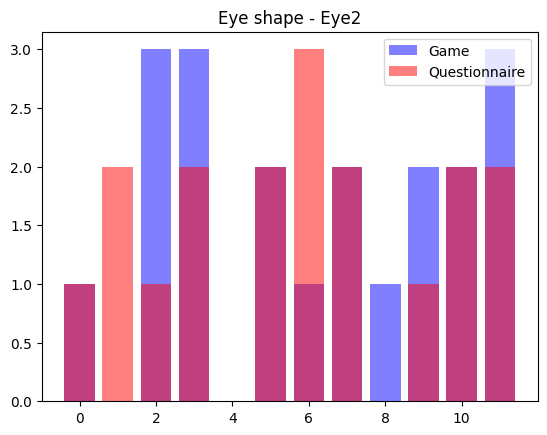

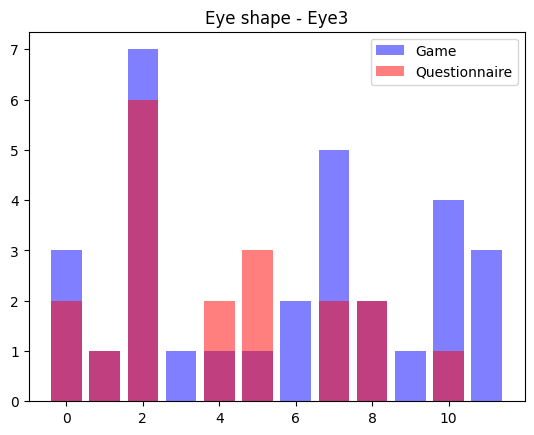

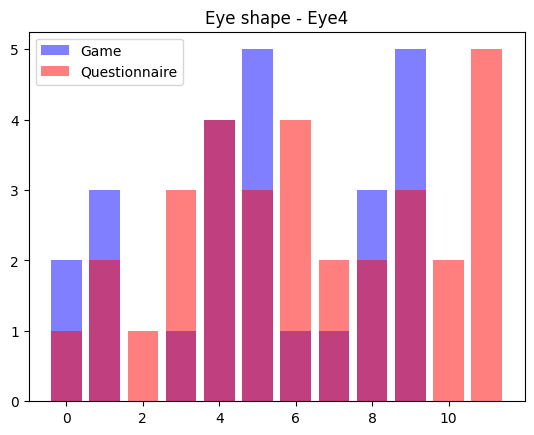

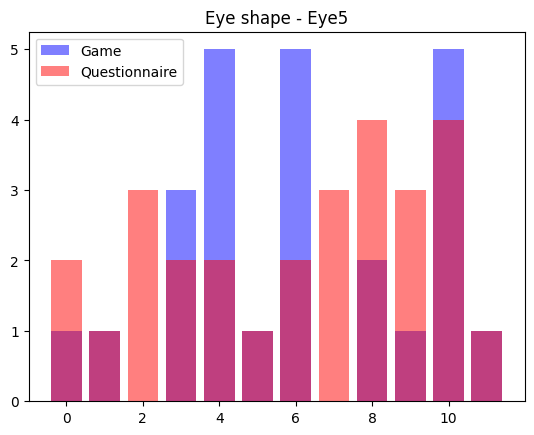

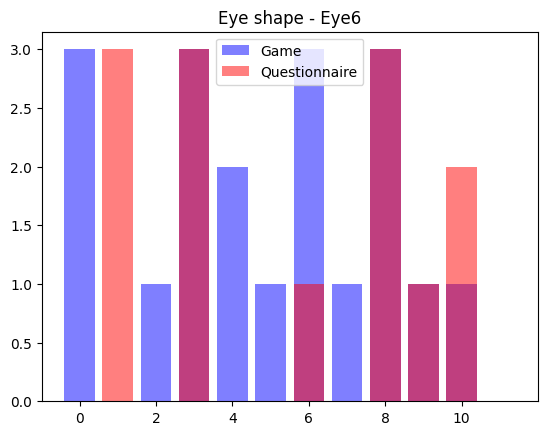

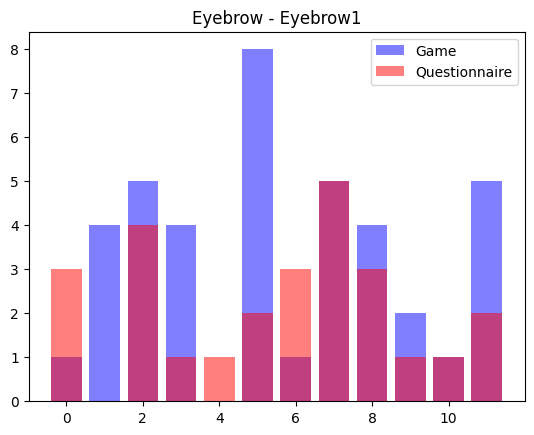

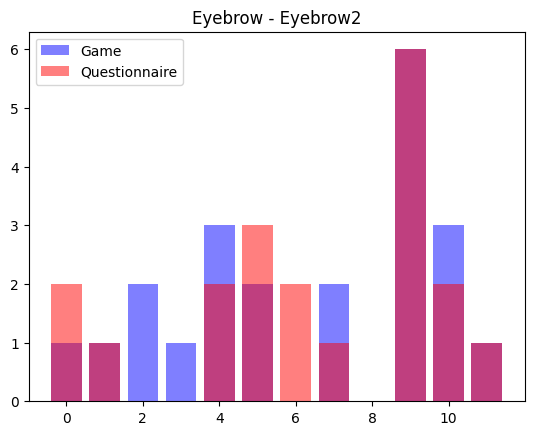

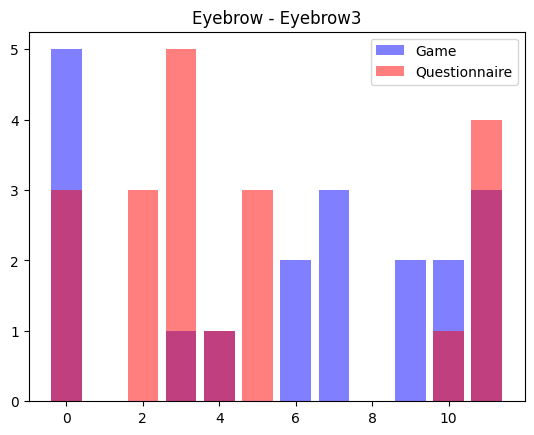

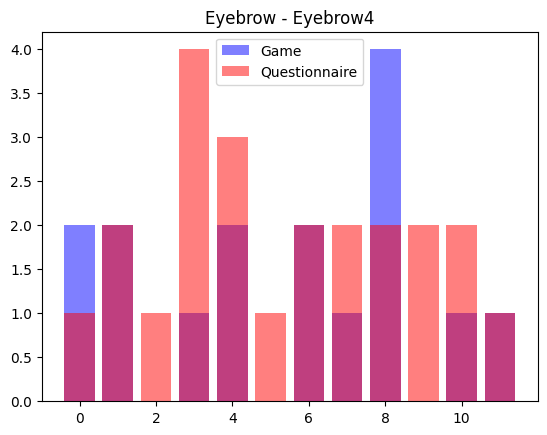

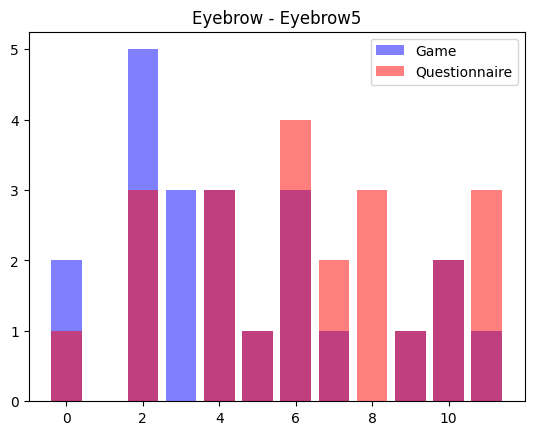

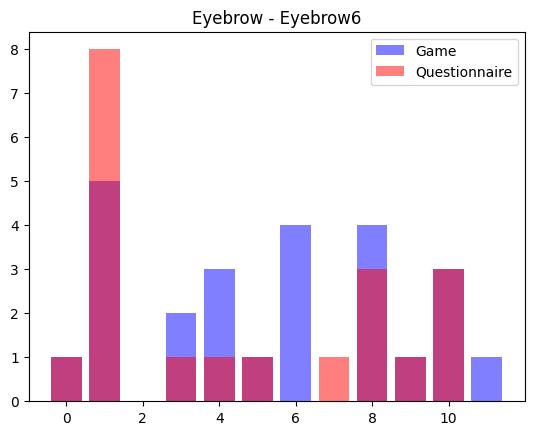

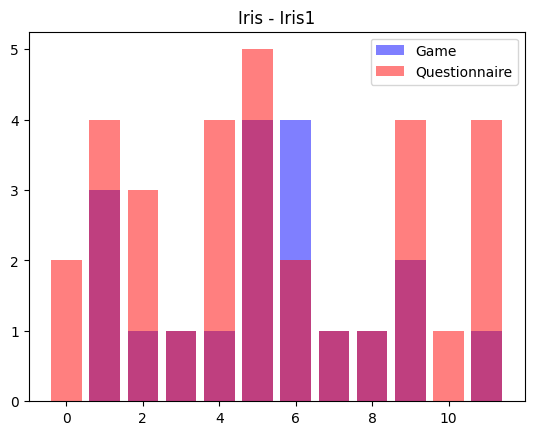

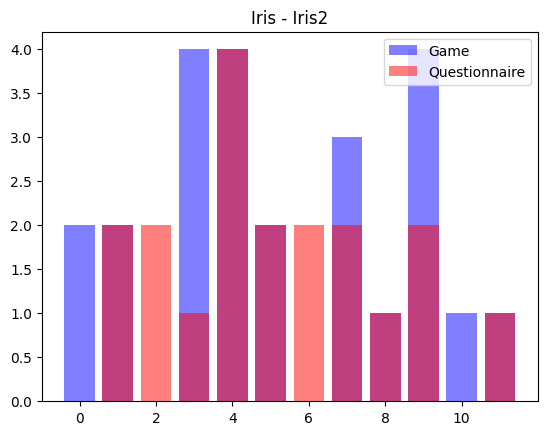

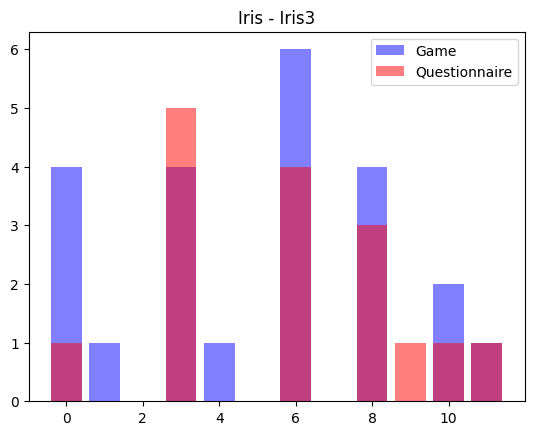

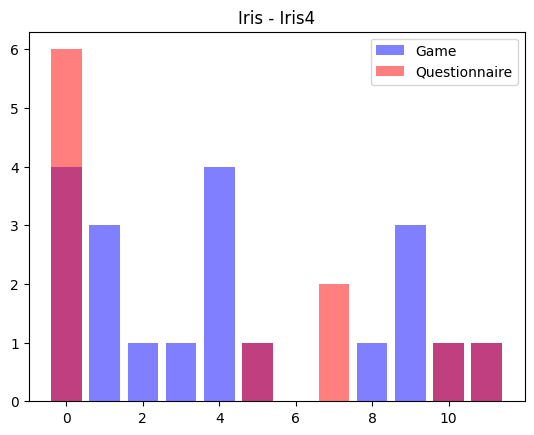

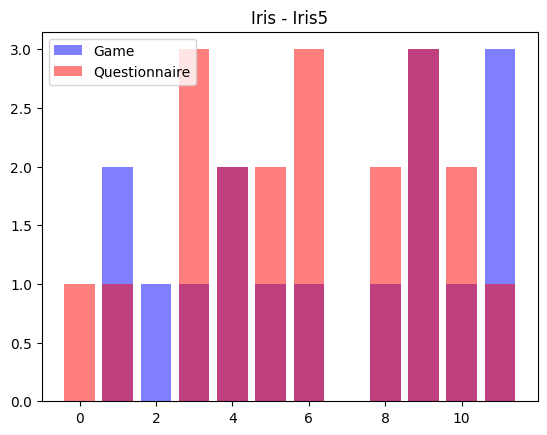

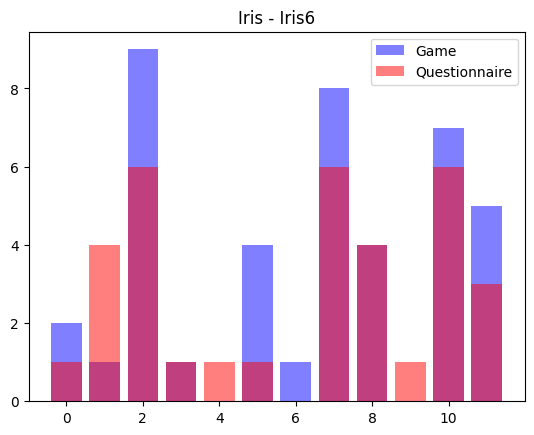

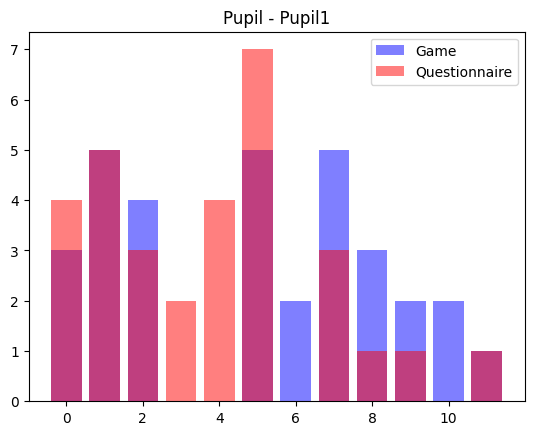

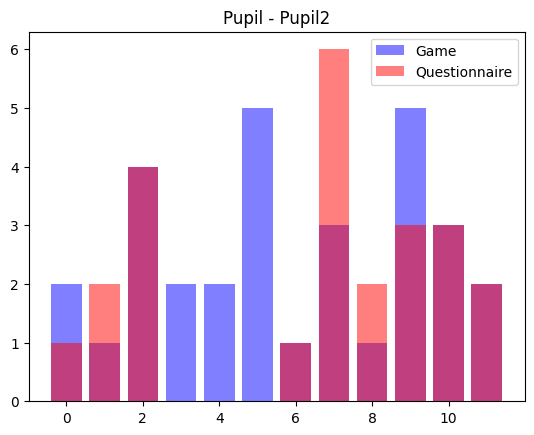

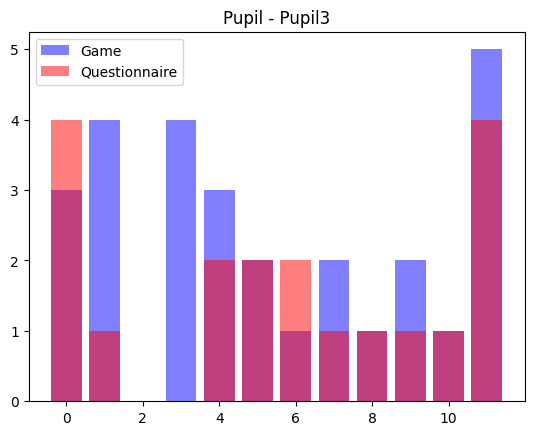

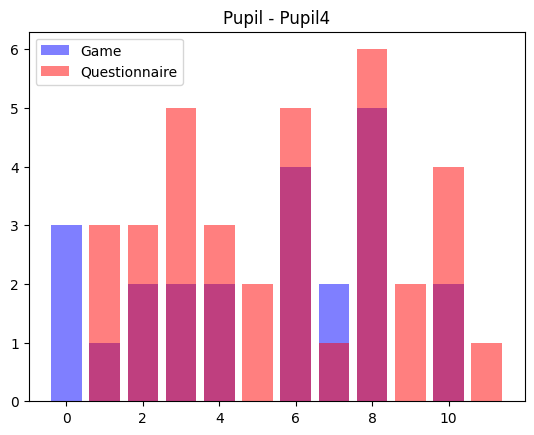

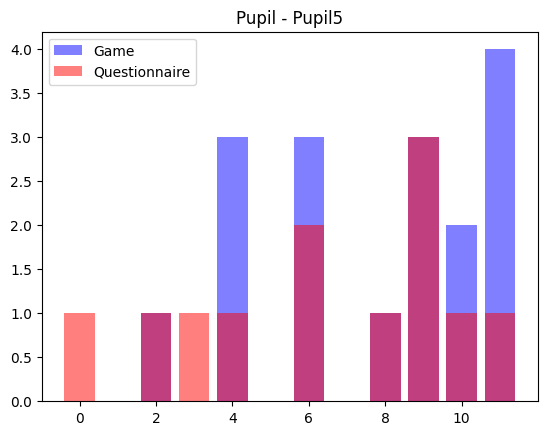

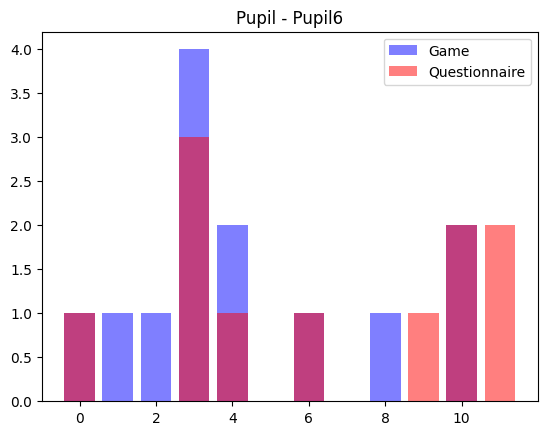

In [5]:


for (shape_type, shape_name) in [(EYE_SHAPE_TR, "eye_shape"), (EYEBROW_TR, "eyebrow"), (IRIS_TR, "iris"), (PUPIL_TR, "pupil")]:
	options = list(shape_type.values())
	options.sort()

	def plot_option(option, option_name, data : list[Data], **kwargs):
		counts = [0] * len(data[0].answers)
		for d in data:
			for i in range(len(d.answers)):
				if getattr(d.answers[i], option_name) == option:
					counts[i] += 1
		plt.bar(range(len(counts)), counts, **kwargs)

	for option in options:
		plt.title(get_pretty_name(shape_name) + " - " + option)
		plot_option(option, shape_name, gamelogs_raw, color="#0000ff", alpha=0.5)
		plot_option(option, shape_name, questionnaire_raw, color="#ff0000", alpha=0.5)
		plt.legend(["Game", "Questionnaire"])
		plt.show()
		pass
